In [3]:
import zipfile
import os


zip_path = '/content/archive (9).zip'
extract_dir = '/content/data/'


os.makedirs(extract_dir, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Zip file extracted to {extract_dir}")

Zip file extracted to /content/data/


✅ Zip file extracted to /content/data/
Using device: cuda
✅ Train images: 136, Validation images: 35
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 237MB/s]
Epoch 1/10: 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


Epoch 1: Loss=0.5088, Accuracy=72.79%


Epoch 2/10: 100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


Epoch 2: Loss=0.2067, Accuracy=94.12%


Epoch 3/10: 100%|██████████| 9/9 [00:00<00:00,  9.30it/s]


Epoch 3: Loss=0.1330, Accuracy=96.32%


Epoch 4/10: 100%|██████████| 9/9 [00:00<00:00,  9.07it/s]


Epoch 4: Loss=0.0967, Accuracy=97.79%


Epoch 5/10: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


Epoch 5: Loss=0.0652, Accuracy=97.79%


Epoch 6/10: 100%|██████████| 9/9 [00:01<00:00,  7.61it/s]


Epoch 6: Loss=0.0500, Accuracy=98.53%


Epoch 7/10: 100%|██████████| 9/9 [00:00<00:00,  9.06it/s]


Epoch 7: Loss=0.0323, Accuracy=99.26%


Epoch 8/10: 100%|██████████| 9/9 [00:00<00:00,  9.14it/s]


Epoch 8: Loss=0.0316, Accuracy=99.26%


Epoch 9/10: 100%|██████████| 9/9 [00:01<00:00,  8.94it/s]


Epoch 9: Loss=0.0258, Accuracy=100.00%


Epoch 10/10: 100%|██████████| 9/9 [00:00<00:00,  9.02it/s]


Epoch 10: Loss=0.0213, Accuracy=99.26%
✅ Validation Accuracy: 97.14%


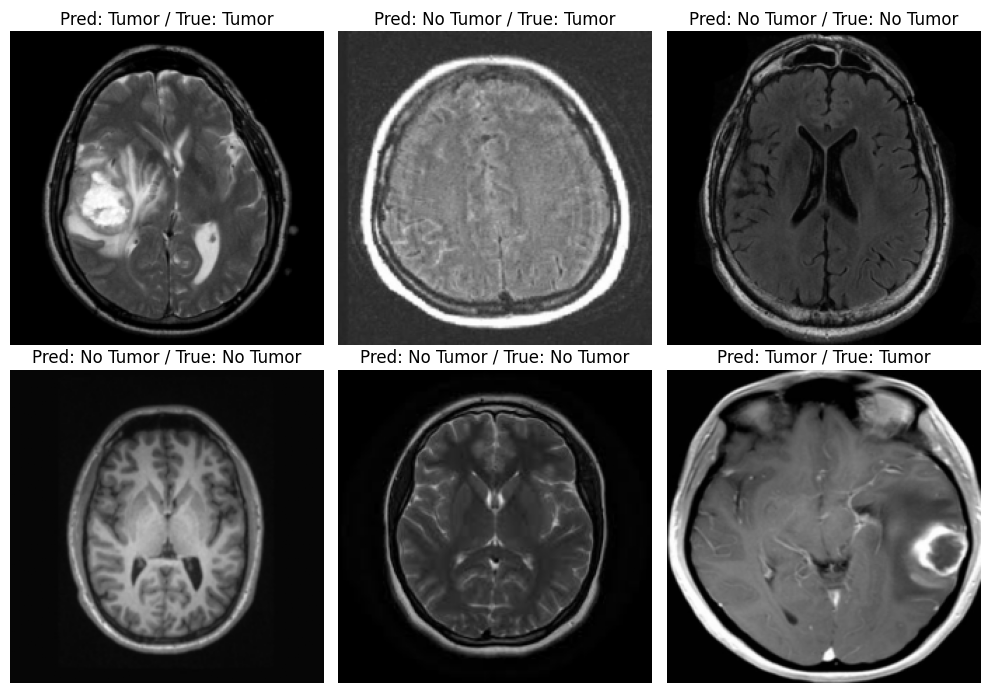

In [4]:

import zipfile
import os

zip_path = '/content/archive (9).zip'    # your dataset zip
extract_dir = '/content/data/'           # extraction directory
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Zip file extracted to {extract_dir}")


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import models
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


class BrainMRIClassifier(Dataset):
    def __init__(self, base_dir, mode='train', transform=None, split_ratio=0.8):
        self.paths = []
        self.labels = []
        for label, folder in enumerate(["no", "yes"]):
            for path in glob.glob(os.path.join(base_dir, folder, "*.jpg")):
                self.paths.append(path)
                self.labels.append(label)

        # Split train/test
        X_train, X_val, y_train, y_val = train_test_split(
            self.paths, self.labels, test_size=1-split_ratio, random_state=42, stratify=self.labels
        )

        if mode == 'train':
            self.paths, self.labels = X_train, y_train
        else:
            self.paths, self.labels = X_val, y_val

        if transform is None:
            if mode == 'train':
                self.transform = T.Compose([
                    T.ToPILImage(),
                    T.Resize((224,224)),
                    T.RandomHorizontalFlip(),
                    T.RandomRotation(15),
                    T.ToTensor(),
                ])
            else:
                self.transform = T.Compose([
                    T.ToPILImage(),
                    T.Resize((224,224)),
                    T.ToTensor(),
                ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# Create dataset loaders
train_data = BrainMRIClassifier(extract_dir, mode='train')
val_data = BrainMRIClassifier(extract_dir, mode='val')

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

print(f" Train images: {len(train_data)}, Validation images: {len(val_data)}")


model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss={train_loss/len(train_loader):.4f}, Accuracy={acc:.2f}%")


model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
val_acc = 100 * correct / total
print(f"✅ Validation Accuracy: {val_acc:.2f}%")


labels_map = {0: "No Tumor", 1: "Tumor"}
model.eval()
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.flatten()
for i in range(6):
    idx = random.randint(0, len(val_data)-1)
    img, label = val_data[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_label = torch.argmax(pred, 1).item()
    ax[i].imshow(np.transpose(img.numpy(), (1,2,0)))
    ax[i].set_title(f"Pred: {labels_map[pred_label]} / True: {labels_map[label.item()]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


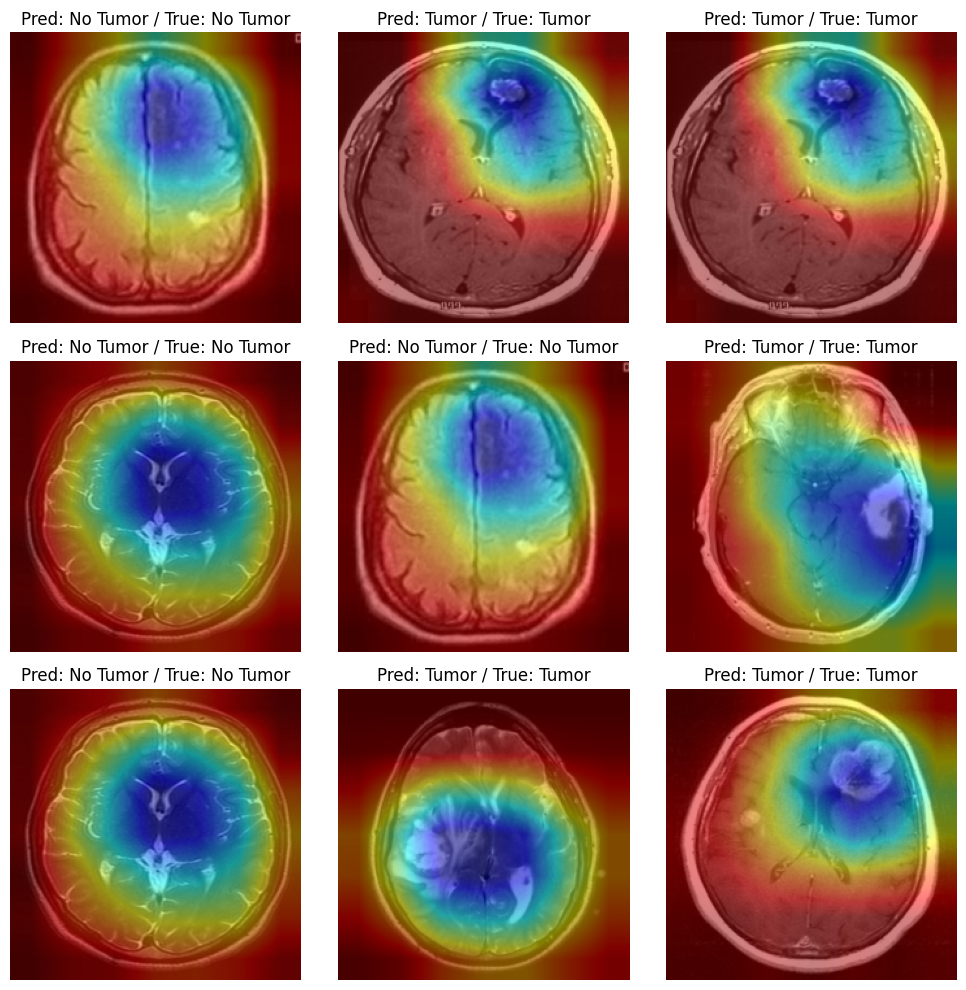

✅ Pseudo masks saved to: /content/pseudo_masks/


In [5]:

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Grad-CAM helper class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        target = output[0, target_class]
        target.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Target layer = last convolution layer in ResNet
target_layer = model.layer4[-1]
grad_cam = GradCAM(model, target_layer)

save_dir = "/content/pseudo_masks/"
os.makedirs(save_dir, exist_ok=True)

model.eval()
labels_map = {0: "No Tumor", 1: "Tumor"}

def apply_heatmap_on_image(img_tensor, cam):
    img = np.transpose(img_tensor.numpy(), (1,2,0))
    img = (img - img.min()) / (img.max() - img.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = 0.5 * heatmap + 0.5 * img
    return np.clip(overlay, 0, 1)

# Visualize a few Grad-CAMs
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax = ax.flatten()

for i in range(9):
    idx = np.random.randint(0, len(val_data))
    img, label = val_data[idx]
    img_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_input)
    pred_label = torch.argmax(pred, 1).item()

    cam = grad_cam.generate(img_input, target_class=pred_label)
    overlay = apply_heatmap_on_image(img, cam)

    # Save pseudo mask (optional — threshold at 0.5)
    pseudo_mask = (cam > 0.5).astype(np.uint8) * 255
    filename = os.path.basename(val_data.paths[idx]).replace('.jpg', '_mask.jpg')
    cv2.imwrite(os.path.join(save_dir, filename), pseudo_mask)

    ax[i].imshow(overlay)
    ax[i].set_title(f"Pred: {labels_map[pred_label]} / True: {labels_map[label.item()]}")
    ax[i].axis('off')

plt.tight_layout()
plt.show()

print(f" Pseudo masks saved to: {save_dir}")


In [16]:
# Create proper folder structure for ResU-Net
!mkdir -p /content/data_for_resunet/images
!mkdir -p /content/data_for_resunet/masks

import shutil, glob

for img_path in glob.glob('/content/data/yes/*.jpg') + glob.glob('/content/data/no/*.jpg'):
    filename = os.path.basename(img_path)
    mask_path = os.path.join('/content/pseudo_masks', filename.replace('.jpg', '_mask.jpg'))
    if os.path.exists(mask_path):
        shutil.copy(img_path, '/content/data_for_resunet/images/')
        shutil.copy(mask_path, '/content/data_for_resunet/masks/')


Images shape: (6, 256, 256, 3)
Masks shape: (6, 256, 256, 1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_30[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │    131,200 │ conv2d_31[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │    295,040 │ concatenate_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_32[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 256, 256,  │     32,832 │ conv2d_33[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │     73,792 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_34[0][0] 

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7049 - loss: 0.6901 - val_accuracy: 0.7907 - val_loss: 0.6423
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7314 - loss: 0.6767 - val_accuracy: 0.7907 - val_loss: 0.5990
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7314 - loss: 0.6956 - val_accuracy: 0.7907 - val_loss: 0.6112
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7314 - loss: 0.6635 - val_accuracy: 0.7907 - val_loss: 0.6274
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7314 - loss: 0.6617 - val_accuracy: 0.7907 - val_loss: 0.6277
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7314 - loss: 0.6562 - val_accuracy: 0.7907 - val_loss: 0.6051
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7314 - loss: 0.6401 - val_accuracy: 0.7907 - val_loss: 0.5513
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7314 - loss: 0.6194 - val_accuracy: 0.7907 - val_loss: 0.

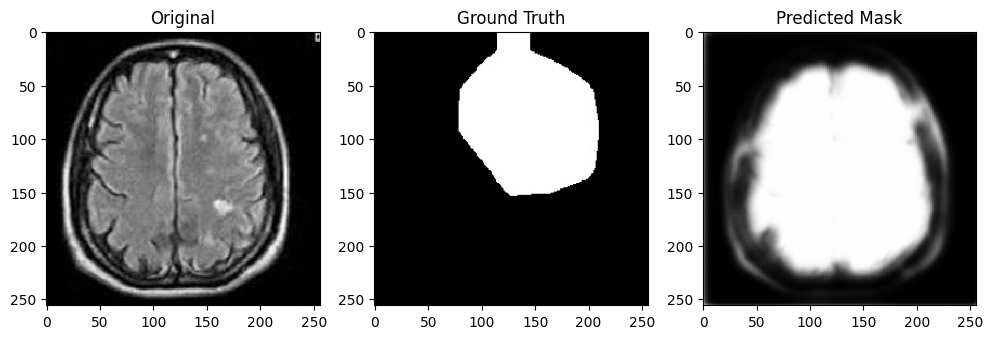

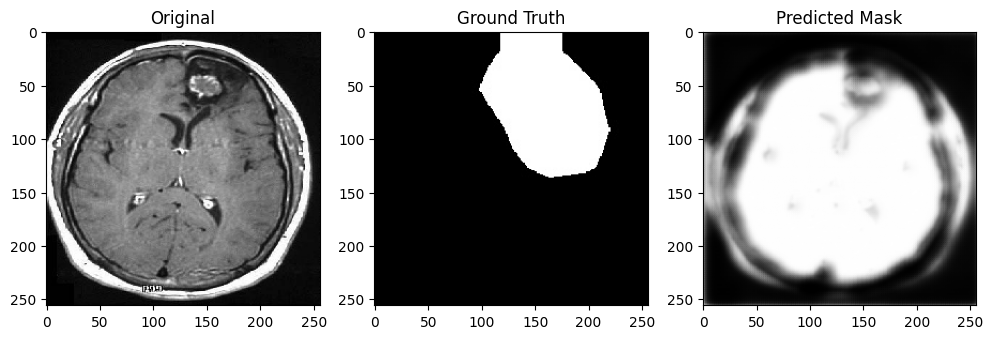

In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths
IMG_DIR = "/content/data_for_resunet/images/"
MASK_DIR = "/content/data_for_resunet/masks/"

# Image settings
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
def load_data(img_dir, mask_dir):
    images = []
    masks = []
    image_files = sorted(os.listdir(img_dir))

    for filename in image_files:
        img_path = os.path.join(img_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_mask.jpg'))

        if not os.path.exists(mask_path):
            continue

        # Load and normalize image
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img = img_to_array(img) / 255.0

        # Load and normalize mask
        mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, Y = load_data(IMG_DIR, MASK_DIR)

print("Images shape:", X.shape)
print("Masks shape:", Y.shape)

# Train–validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
from tensorflow.keras import layers, models

def resunet(input_shape=(256,256,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    bn = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    bn = layers.Conv2D(256, (3,3), activation='relu', padding='same')(bn)

    # Decoder
    u2 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(bn)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)

    u3 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c3)
    u3 = layers.concatenate([u3, c1])
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = resunet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=20,
    verbose=1
)
preds = model.predict(X_val) # Predict on all validation data
for i in range(len(X_val)): # Iterate only up to the number of validation samples
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(X_val[i])
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.show()

Loaded pairs: (6, 256, 256, 3) (6, 256, 256, 1)
Train: (4, 256, 256, 3) (4, 256, 256, 1) Val: (2, 256, 256, 3) (2, 256, 256, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_68[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 128, 128,  │          0 │ conv2d_69[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_70[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_71[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_12… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_72[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_13… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_74[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_75[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_14… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_76[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │  2,097,664 │ conv2d_77[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 32, 32,    │    131,328 │ conv2d_75[0][0] 

 Total params: 31,381,349 (119.71 MB)

 Trainable params: 31,381,349 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.6471 - dice_coef: 0.3358 - loss: 1.3552
Epoch 1: val_dice_coef improved from -inf to 0.29273, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.6471 - dice_coef: 0.3358 - loss: 1.3552 - val_accuracy: 0.7608 - val_dice_coef: 0.2927 - val_loss: 1.3955 - learning_rate: 1.0000e-04
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7096 - dice_coef: 0.3359 - loss: 1.3553
Epoch 2: val_dice_coef improved from 0.29273 to 0.29355, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7096 - dice_coef: 0.3359 - loss: 1.3553 - val_accuracy: 0.7602 - val_dice_coef: 0.2935 - val_loss: 1.3967 - learning_rate: 1.0000e-04
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7065 - dice_coef: 0.3389 - loss: 1.3525
Epoch 3: val_dice_coef improved from 0.29355 to 0.29426, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7065 - dice_coef: 0.3389 - loss: 1.3525 - val_accuracy: 0.6265 - val_dice_coef: 0.2943 - val_loss: 1.3976 - learning_rate: 1.0000e-04
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7000 - dice_coef: 0.3349 - loss: 1.3567
Epoch 4: val_dice_coef improved from 0.29426 to 0.29489, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7000 - dice_coef: 0.3349 - loss: 1.3567 - val_accuracy: 0.5347 - val_dice_coef: 0.2949 - val_loss: 1.3984 - learning_rate: 1.0000e-04
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6853 - dice_coef: 0.3382 - loss: 1.3535
Epoch 5: val_dice_coef improved from 0.29489 to 0.29546, saving model to /content/checkpoints/att_resunet_best.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6853 - dice_coef: 0.3382 - loss: 1.3535 - val_accuracy: 0.5038 - val_dice_coef: 0.2955 - val_loss: 1.3991 - learning_rate: 1.0000e-04
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6620 - dice_coef: 0.3441 - loss: 1.3477
Epoch 6: val_dice_coef improved from 0.29546 to 0.29572, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6620 - dice_coef: 0.3441 - loss: 1.3477 - val_accuracy: 0.4957 - val_dice_coef: 0.2957 - val_loss: 1.3994 - learning_rate: 5.0000e-05
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6687 - dice_coef: 0.3370 - loss: 1.3547
Epoch 7: val_dice_coef improved from 0.29572 to 0.29598, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6687 - dice_coef: 0.3370 - loss: 1.3547 - val_accuracy: 0.4901 - val_dice_coef: 0.2960 - val_loss: 1.3997 - learning_rate: 5.0000e-05
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6622 - dice_coef: 0.3449 - loss: 1.3466
Epoch 8: val_dice_coef improved from 0.29598 to 0.29623, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6622 - dice_coef: 0.3449 - loss: 1.3466 - val_accuracy: 0.4866 - val_dice_coef: 0.2962 - val_loss: 1.3999 - learning_rate: 5.0000e-05
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.6579 - dice_coef: 0.3389 - loss: 1.3527
Epoch 9: val_dice_coef improved from 0.29623 to 0.29646, saving model to /content/checkpoints/att_resunet_best.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6579 - dice_coef: 0.3389 - loss: 1.3527 - val_accuracy: 0.4851 - val_dice_coef: 0.2965 - val_loss: 1.4001 - learning_rate: 5.0000e-05
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6625 - dice_coef: 0.3415 - loss: 1.3499
Epoch 10: val_dice_coef improved from 0.29646 to 0.29657, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6625 - dice_coef: 0.3415 - loss: 1.3499 - val_accuracy: 0.4846 - val_dice_coef: 0.2966 - val_loss: 1.4002 - learning_rate: 2.5000e-05
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6575 - dice_coef: 0.3420 - loss: 1.3494
Epoch 11: val_dice_coef improved from 0.29657 to 0.29669, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6575 - dice_coef: 0.3420 - loss: 1.3494 - val_accuracy: 0.4846 - val_dice_coef: 0.2967 - val_loss: 1.4002 - learning_rate: 2.5000e-05
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6578 - dice_coef: 0.3427 - loss: 1.3485
Epoch 12: val_dice_coef improved from 0.29669 to 0.29680, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6578 - dice_coef: 0.3427 - loss: 1.3485 - val_accuracy: 0.4849 - val_dice_coef: 0.2968 - val_loss: 1.4003 - learning_rate: 2.5000e-05
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6604 - dice_coef: 0.3442 - loss: 1.3469
Epoch 13: val_dice_coef improved from 0.29680 to 0.29691, saving model to /content/checkpoints/att_resunet_best.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6604 - dice_coef: 0.3442 - loss: 1.3469 - val_accuracy: 0.4852 - val_dice_coef: 0.2969 - val_loss: 1.4003 - learning_rate: 2.5000e-05
Epoch 14/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6666 - dice_coef: 0.3380 - loss: 1.3529
Epoch 14: val_dice_coef improved from 0.29691 to 0.29696, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.6666 - dice_coef: 0.3380 - loss: 1.3529 - val_accuracy: 0.4854 - val_dice_coef: 0.2970 - val_loss: 1.4004 - learning_rate: 1.2500e-05
Epoch 15/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6650 - dice_coef: 0.3427 - loss: 1.3481
Epoch 15: val_dice_coef improved from 0.29696 to 0.29702, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6650 - dice_coef: 0.3427 - loss: 1.3481 - val_accuracy: 0.4856 - val_dice_coef: 0.2970 - val_loss: 1.4004 - learning_rate: 1.2500e-05
Epoch 16/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6679 - dice_coef: 0.3383 - loss: 1.3525
Epoch 16: val_dice_coef improved from 0.29702 to 0.29707, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6679 - dice_coef: 0.3383 - loss: 1.3525 - val_accuracy: 0.4858 - val_dice_coef: 0.2971 - val_loss: 1.4004 - learning_rate: 1.2500e-05
Epoch 17/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6563 - dice_coef: 0.3430 - loss: 1.3480
Epoch 17: val_dice_coef improved from 0.29707 to 0.29713, saving model to /content/checkpoints/att_resunet_best.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6563 - dice_coef: 0.3430 - loss: 1.3480 - val_accuracy: 0.4861 - val_dice_coef: 0.2971 - val_loss: 1.4004 - learning_rate: 1.2500e-05
Epoch 18/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6543 - dice_coef: 0.3470 - loss: 1.3439
Epoch 18: val_dice_coef improved from 0.29713 to 0.29715, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6543 - dice_coef: 0.3470 - loss: 1.3439 - val_accuracy: 0.4864 - val_dice_coef: 0.2972 - val_loss: 1.4004 - learning_rate: 6.2500e-06
Epoch 19/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6601 - dice_coef: 0.3389 - loss: 1.3520
Epoch 19: val_dice_coef improved from 0.29715 to 0.29718, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6601 - dice_coef: 0.3389 - loss: 1.3520 - val_accuracy: 0.4867 - val_dice_coef: 0.2972 - val_loss: 1.4004 - learning_rate: 6.2500e-06
Epoch 20/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6534 - dice_coef: 0.3499 - loss: 1.3409
Epoch 20: val_dice_coef improved from 0.29718 to 0.29720, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6534 - dice_coef: 0.3499 - loss: 1.3409 - val_accuracy: 0.4869 - val_dice_coef: 0.2972 - val_loss: 1.4004 - learning_rate: 6.2500e-06
Epoch 21/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6581 - dice_coef: 0.3437 - loss: 1.3471
Epoch 21: val_dice_coef improved from 0.29720 to 0.29723, saving model to /content/checkpoints/att_resunet_best.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6581 - dice_coef: 0.3437 - loss: 1.3471 - val_accuracy: 0.4872 - val_dice_coef: 0.2972 - val_loss: 1.4004 - learning_rate: 6.2500e-06
Epoch 22/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6429 - dice_coef: 0.3543 - loss: 1.3367
Epoch 22: val_dice_coef improved from 0.29723 to 0.29724, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6429 - dice_coef: 0.3543 - loss: 1.3367 - val_accuracy: 0.4874 - val_dice_coef: 0.2972 - val_loss: 1.4004 - learning_rate: 3.1250e-06
Epoch 23/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6597 - dice_coef: 0.3462 - loss: 1.3444
Epoch 23: val_dice_coef improved from 0.29724 to 0.29725, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6597 - dice_coef: 0.3462 - loss: 1.3444 - val_accuracy: 0.4876 - val_dice_coef: 0.2973 - val_loss: 1.4004 - learning_rate: 3.1250e-06
Epoch 24/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6676 - dice_coef: 0.3408 - loss: 1.3497
Epoch 24: val_dice_coef improved from 0.29725 to 0.29727, saving model to /content/checkpoints/att_resunet_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6676 - dice_coef: 0.3408 - loss: 1.3497 - val_accuracy: 0.4878 - val_dice_coef: 0.2973 - val_loss: 1.4004 - learning_rate: 3.1250e-06
Epoch 25/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6645 - dice_coef: 0.3433 - loss: 1.3472
Epoch 25: val_dice_coef improved from 0.29727 to 0.29728, saving model to /content/checkpoints/att_resunet_best.h5



Epoch 25: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6645 - dice_coef: 0.3433 - loss: 1.3472 - val_accuracy: 0.4878 - val_dice_coef: 0.2973 - val_loss: 1.4004 - learning_rate: 3.1250e-06
Restoring model weights from the end of the best epoch: 25.


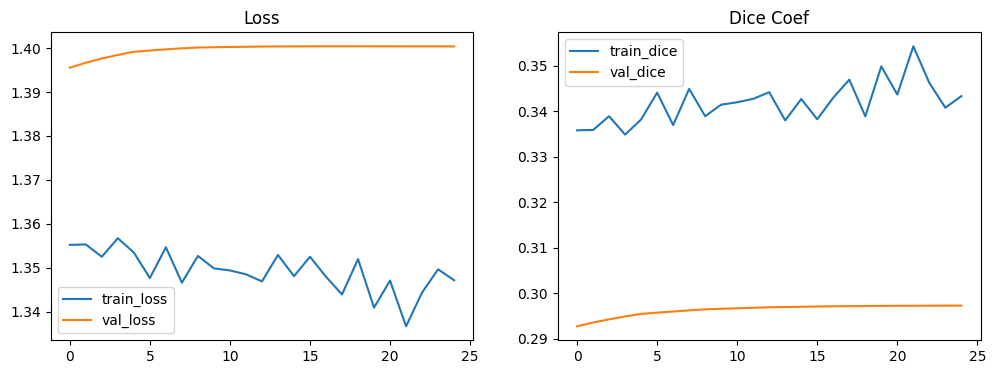

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


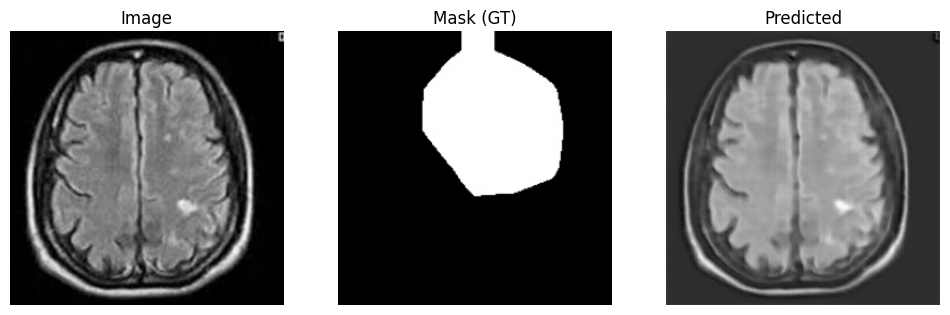

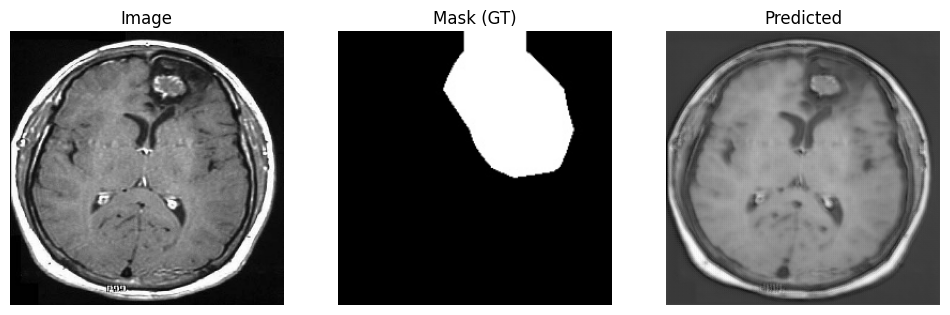

Saved model to /content/att_resunet_final.h5


In [31]:

import os, glob, cv2, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Paths (adjust if different)
IMG_DIR  = "/content/data_for_resunet/images/"
MASK_DIR = "/content/data_for_resunet/masks/"

IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 25
SEED = 42

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)

# -------------------------
# 2) Load image / mask pairs
# -------------------------
def load_pairs(img_dir, mask_dir, img_exts=("*.jpg","*.png","*.jpeg")):
    images = []
    masks  = []
    file_list = []
    # gather image files
    files = []
    for ext in img_exts:
        files += sorted(glob.glob(os.path.join(img_dir, ext)))
    for img_path in files:
        name = os.path.basename(img_path)
        mask_name = name.replace('.jpg','_mask.jpg').replace('.jpeg','_mask.jpg').replace('.png','_mask.png')
        mask_path = os.path.join(mask_dir, mask_name)
        if not os.path.exists(mask_path):
            continue
        # read and resize
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = np.expand_dims(mask, axis=-1) / 255.0
        images.append(img.astype(np.float32))
        masks.append(mask.astype(np.float32))
        file_list.append(name)
    return np.array(images), np.array(masks), file_list

X, Y, files = load_pairs(IMG_DIR, MASK_DIR)
print("Loaded pairs:", X.shape, Y.shape)

# quick guard
if len(X) == 0:
    raise SystemExit("No image-mask pairs found. Check IMG_DIR and MASK_DIR and naming convention (image -> image_mask.jpg).")

# split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=SEED)
print("Train:", X_train.shape, Y_train.shape, "Val:", X_val.shape, Y_val.shape)


data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.02,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Fit not necessary as we work with float arrays

def generator(X, Y, batch_size):
    idxs = np.arange(len(X))
    while True:
        np.random.shuffle(idxs)
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_idx = idxs[start:end]
            batch_imgs = X[batch_idx]
            batch_masks= Y[batch_idx]
            # apply identical transforms to images and masks
            seed = np.random.randint(0, 1e6)
            # Corrected: Directly use the flow method which returns an iterator
            imgs_aug_iterator = image_datagen.flow(batch_imgs, batch_size=len(batch_imgs), shuffle=False, seed=seed)
            masks_aug_iterator = mask_datagen.flow(batch_masks, batch_size=len(batch_masks), shuffle=False, seed=seed)

            # Get the next batch from the iterators
            imgs_aug = next(imgs_aug_iterator)
            masks_aug = next(masks_aug_iterator)

            yield imgs_aug, masks_aug


def attention_block(x, g, inter_channels):
    """
    x : skip connection (encoder feature map)
    g : gating signal (decoder feature map)
    """
    theta_x = layers.Conv2D(inter_channels, (1,1), strides=(1,1), padding='same')(x)
    phi_g   = layers.Conv2D(inter_channels, (1,1), strides=(1,1), padding='same')(g)
    add     = layers.Add()([theta_x, phi_g])
    act     = layers.Activation('relu')(add)
    psi     = layers.Conv2D(1, (1,1), padding='same')(act)
    psi     = layers.Activation('sigmoid')(psi)
    # upsample psi if needed to x's spatial size (should match in this architecture)
    mul     = layers.Multiply()([x, psi])
    return mul

def attention_resunet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    b = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    b = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(b)

    # Decoder with attention gates
    u4 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(b)
    att4 = attention_block(c4, u4, inter_channels=256)
    u4 = layers.Concatenate()([u4, att4])
    c5 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c5)

    u3 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c5)
    att3 = attention_block(c3, u3, inter_channels=128)
    u3 = layers.Concatenate()([u3, att3])
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c6)

    u2 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c6)
    att2 = attention_block(c2, u2, inter_channels=64)
    u2 = layers.Concatenate()([u2, att2])
    c7 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c7)

    u1 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c7)
    att1 = attention_block(c1, u1, inter_channels=32)
    u1 = layers.Concatenate()([u1, att1])
    c8 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = attention_resunet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=bce_dice_loss, metrics=[dice_coef, 'accuracy'])
model.summary()

os.makedirs("/content/checkpoints", exist_ok=True)
chk = ModelCheckpoint("/content/checkpoints/att_resunet_best.h5", monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
es  = EarlyStopping(monitor='val_dice_coef', mode='max', patience=8, restore_best_weights=True, verbose=1)

train_gen = generator(X_train, Y_train, BATCH_SIZE)
val_gen   = generator(X_val, Y_val, BATCH_SIZE)

steps_per_epoch = max(1, len(X_train)//BATCH_SIZE)
val_steps = max(1, len(X_val)//BATCH_SIZE)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[chk, rlr, es]
)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='train_dice')
plt.plot(history.history.get('val_dice_coef', []), label='val_dice')
plt.legend(); plt.title("Dice Coef")
plt.show()


def show_results(model, X, Y, n=5):
    preds = model.predict(X[:n])
    for i in range(min(n, len(X))): # Ensure we don't exceed the number of samples
        fig, ax = plt.subplots(1,3, figsize=(12,4))
        ax[0].imshow(X[i]); ax[0].set_title("Image"); ax[0].axis('off')
        ax[1].imshow(Y[i].squeeze(), cmap='gray'); ax[1].set_title("Mask (GT)"); ax[1].axis('off')
        ax[2].imshow(preds[i].squeeze(), cmap='gray'); ax[2].set_title("Predicted"); ax[2].axis('off')
        plt.show()

show_results(model, X_val, Y_val, n=5)


model.save("/content/att_resunet_final.h5")
print("Saved model to /content/att_resunet_final.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

================ FINAL VALIDATION METRICS ================

Dice Coefficient: 0.4290
IoU            : 0.2778
Precision      : 0.2931
Recall         : 0.8311
F1-Score       : 0.4290

Predicted masks saved in: /content/predicted_masks/


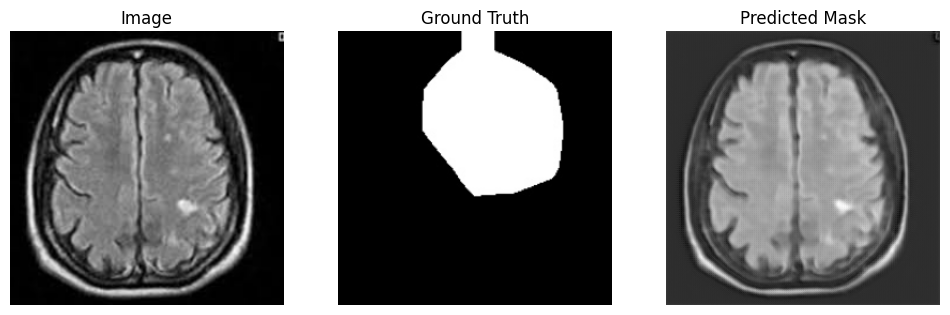

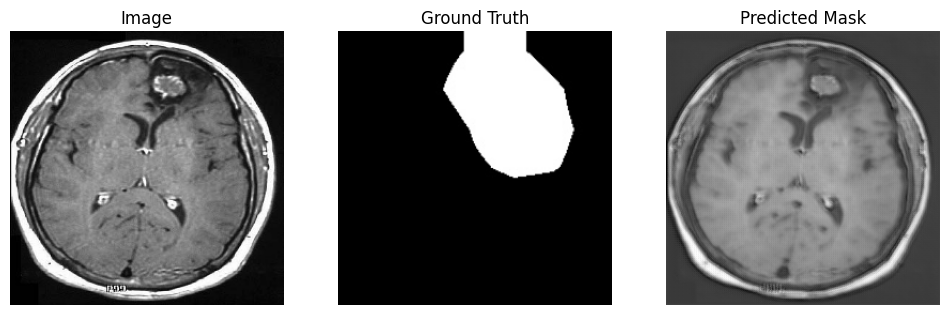

In [33]:


import numpy as np
import cv2, os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt # Import matplotlib for visualization

# Directory for saving predicted masks
pred_dir = "/content/predicted_masks/"
os.makedirs(pred_dir, exist_ok=True)


def compute_metrics(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    y_true_bin = (y_true_f > 0.5).astype(np.uint8)
    y_pred_bin = (y_pred_f > 0.5).astype(np.uint8)

    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin) - intersection

    dice = (2.0 * intersection + smooth) / (np.sum(y_true_bin) + np.sum(y_pred_bin) + smooth)
    iou = (intersection + smooth) / (union + smooth)

    # Handle cases where y_true_bin or y_pred_bin might be all zeros or all ones
    if np.sum(y_true_bin) + np.sum(y_pred_bin) == 0: # Both are empty, Dice/IoU is 1 (perfect match of nothing)
        dice = 1.0
        iou = 1.0
    elif np.sum(y_true_bin) == 0 or np.sum(y_pred_bin) == 0: # One is empty, the other is not
         dice = 0.0
         iou = 0.0



    try:
        tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
    except ValueError:
         # Handle cases where confusion_matrix might fail (e.g., only one class present)
         # If only class 0 is present in both true and pred (all background)
         if np.all(y_true_bin == 0) and np.all(y_pred_bin == 0):
             tn, fp, fn, tp = len(y_true_bin), 0, 0, 0
         # If only class 1 is present in both true and pred (all foreground)
         elif np.all(y_true_bin == 1) and np.all(y_pred_bin == 1):
              tn, fp, fn, tp = 0, 0, 0, len(y_true_bin)
         # If only class 0 in true, but class 1 in pred
         elif np.all(y_true_bin == 0) and np.any(y_pred_bin == 1):
             tn, fp, fn, tp = np.sum(y_true_bin == 0), np.sum(y_pred_bin == 1), 0, 0
         # If only class 1 in true, but class 0 in pred
         elif np.all(y_true_bin == 1) and np.any(y_pred_bin == 0):
             tn, fp, fn, tp = 0, 0, np.sum(y_true_bin == 1), 0
         else: # Should not happen with binary masks if input is correct
            print("Warning: Unhandled confusion matrix case.")
            tn, fp, fn, tp = 0, 0, 0, 0


    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = (2 * precision * recall) / (precision + recall + smooth)


    return dice, iou, precision, recall, f1


try:
    preds_val = model.predict(X_val) # Assuming 'model' and 'X_val' are defined in previous cells
    preds_val_bin = (preds_val > 0.5).astype(np.uint8)

    # Compute metrics for each image
    dice_scores, iou_scores, prec_scores, rec_scores, f1_scores = [], [], [], [], []
    if len(X_val) > 0:
        for i in range(len(X_val)):
            # Assuming Y_val is also available from a previous cell
            d, iou, p, r, f1 = compute_metrics(Y_val[i], preds_val_bin[i])
            dice_scores.append(d)
            iou_scores.append(iou)
            prec_scores.append(p)
            rec_scores.append(r)
            f1_scores.append(f1)

            # Save predicted mask for inspection
            mask_out = (preds_val_bin[i].squeeze() * 255).astype(np.uint8)
            fname = f"pred_{i:03d}.png"
            cv2.imwrite(os.path.join(pred_dir, fname), mask_out)

        # Aggregate mean metrics
        results = {
            "Dice Coefficient": np.mean(dice_scores),
            "IoU": np.mean(iou_scores),
            "Precision": np.mean(prec_scores),
            "Recall": np.mean(rec_scores),
            "F1-Score": np.mean(f1_scores)
        }

        # Display results
        print("\nFINAL VALIDATION METRICS=\n")
        for k, v in results.items():
            print(f"{k:<15}: {v:.4f}")
        print("\n")
        print(f"Predicted masks saved in: {pred_dir}")

        # Optional: visualize random predictions
        n_show = 4
        # Corrected: Ensure n_show does not exceed the number of validation samples
        num_samples_to_show = min(n_show, len(X_val))
        if num_samples_to_show > 0:
            idxs = np.random.choice(len(X_val), num_samples_to_show, replace=False)
            for i in idxs:
                fig, ax = plt.subplots(1,3, figsize=(12,4))
                ax[0].imshow(X_val[i]); ax[0].set_title("Image"); ax[0].axis('off')
                ax[1].imshow(Y_val[i].squeeze(), cmap='gray'); ax[1].set_title("Ground Truth"); ax[1].axis('off')
                ax[2].imshow(preds_val[i].squeeze(), cmap='gray'); ax[2].set_title("Predicted Mask"); ax[2].axis('off')
                plt.show()
        else:
            print("No validation samples to visualize.")

    else:
        print("No validation data available for metric computation and visualization.")

except NameError:
    print("Error: 'model', 'X_val', or 'Y_val' not defined. Please ensure previous cells were run successfully.")
except Exception as e:
    print(f"An error occurred during final evaluation: {e}")



In [23]:
import os

# List the contents of the brain_tumor_dataset directory
dataset_path = '/content/data/brain_tumor_dataset/'
if os.path.exists(dataset_path):
    print(f"Contents of {dataset_path}:")
    for item in os.listdir(dataset_path):
        print(item)
else:
    print(f"Directory not found: {dataset_path}")

Contents of /content/data/brain_tumor_dataset/:
yes
no


✅ Data extraction skipped (already done).
Generating masks for 253 images...


Generating Masks:   8%|▊         | 20/253 [00:00<00:01, 192.80it/s]

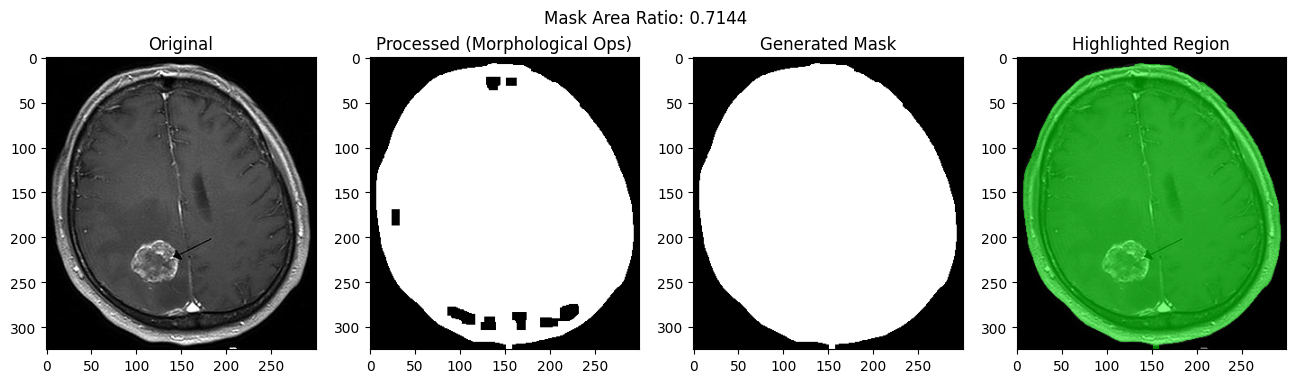

Generating Masks:  16%|█▌        | 40/253 [00:00<00:05, 38.22it/s] 

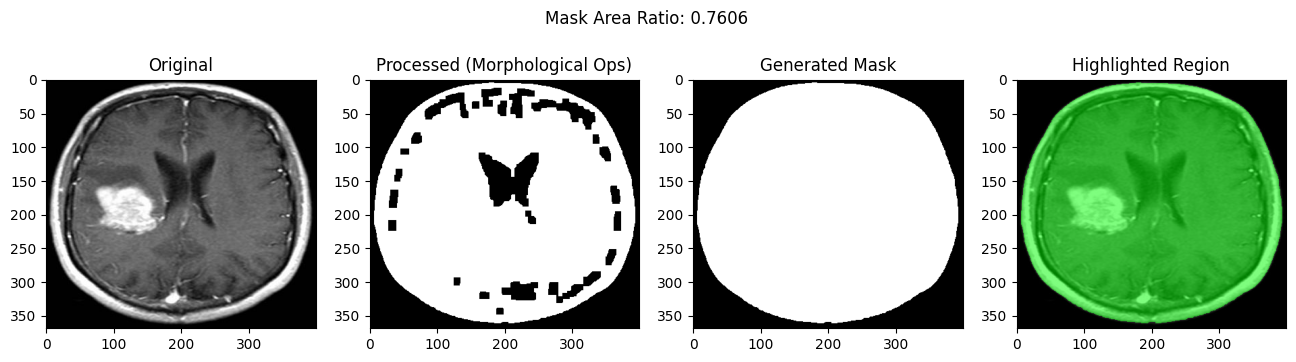

Generating Masks:  53%|█████▎    | 133/253 [00:01<00:01, 111.82it/s]

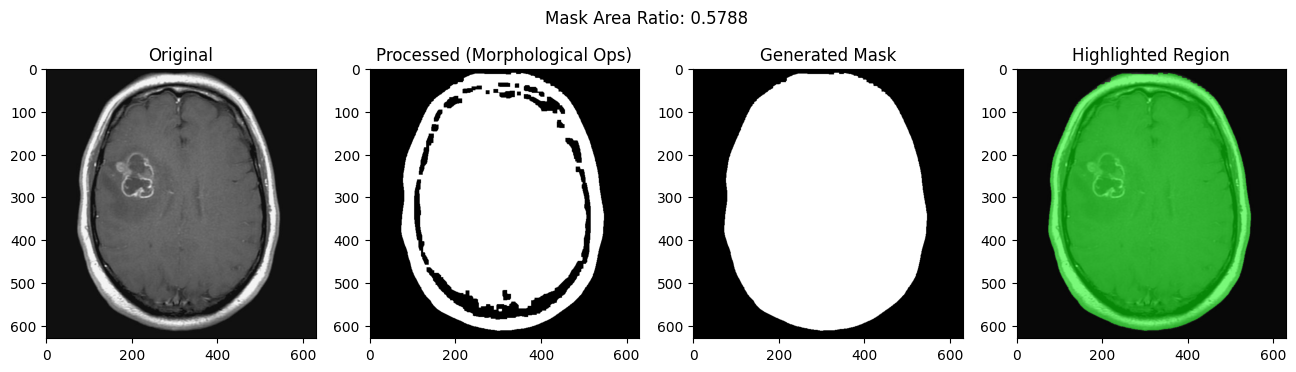

Generating Masks:  60%|██████    | 152/253 [00:02<00:01, 64.26it/s] 

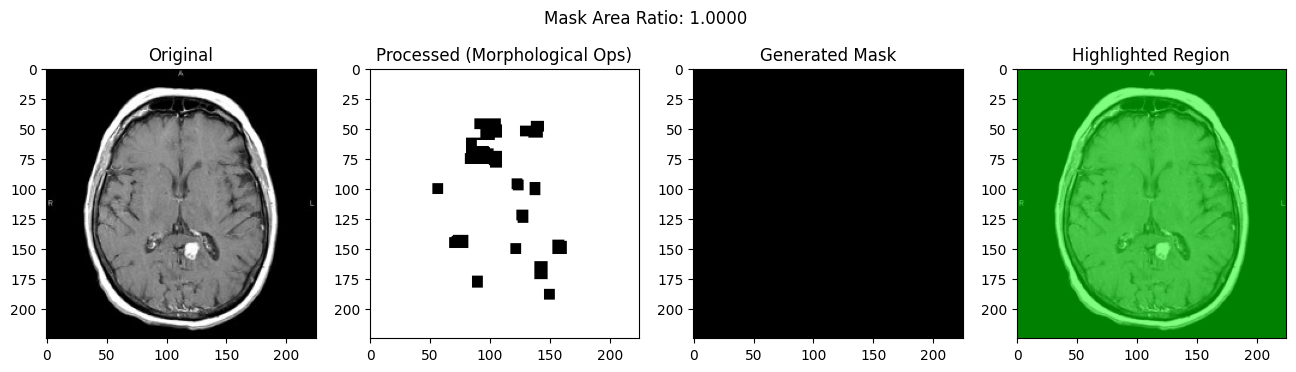

Generating Masks:  75%|███████▍  | 189/253 [00:02<00:00, 67.81it/s]

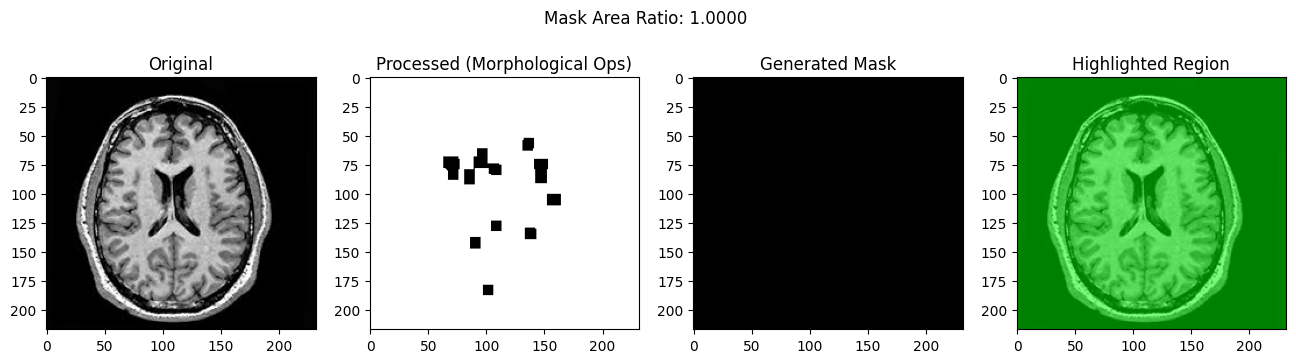

Generating Masks: 100%|██████████| 253/253 [00:03<00:00, 69.16it/s]


✅ Mask generation complete. Avg mask area ratio: 0.8665
Loading image and mask pairs for U-Net training...


Loading Data: 100%|██████████| 253/253 [00:00<00:00, 487.24it/s]


Data shapes: (253, 128, 128, 3) (253, 128, 128, 1)
Train samples: 202, Validation samples: 51


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 1,946,881 (7.43 MB)

 Trainable params: 1,946,881 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 539ms/step - accuracy: 0.7461 - loss: 0.6374 - val_accuracy: 0.8797 - val_loss: 0.3543
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8544 - loss: 0.3504 - val_accuracy: 0.8797 - val_loss: 0.3294
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8461 - loss: 0.3209 - val_accuracy: 0.8797 - val_loss: 0.2947
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8655 - loss: 0.3331 - val_accuracy: 0.8797 - val_loss: 0.3125
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8536 - loss: 0.3155 - val_accuracy: 0.8809 - val_loss: 0.2977
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8450 - loss: 0.3219 - val_accuracy: 0.8810 - val_loss: 0.2497
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8536 - loss: 0.2887 - val_accuracy: 0.8854 - val_loss: 0.2321
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8435 - loss: 0.3027 - val_accuracy: 0.8824 -

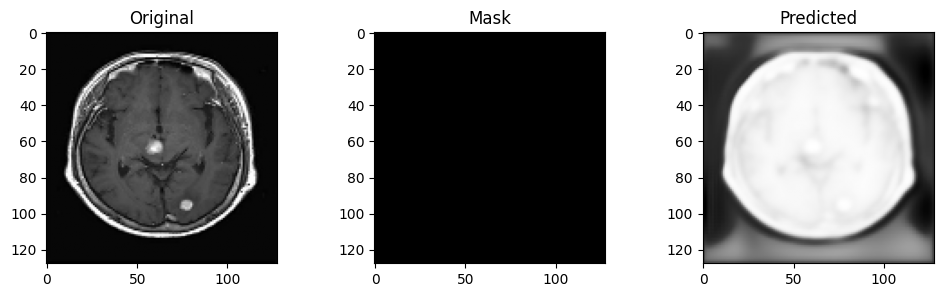

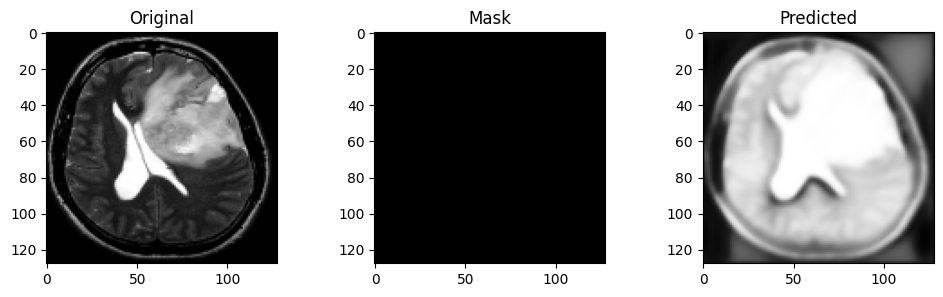

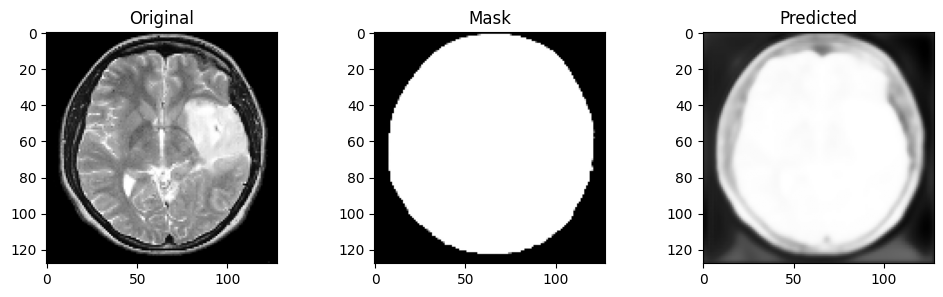

In [25]:

print("✅ Data extraction skipped (already done).")



import cv2, numpy as np, matplotlib.pyplot as plt
import os, random
from tqdm import tqdm # Import tqdm

# Corrected base data directory and mask output directory
base_data_dir = "/content/data/brain_tumor_dataset/"
mask_dir_generated = "/content/generated_masks/" # Directory where masks were saved
os.makedirs(mask_dir_generated, exist_ok=True)


def generate_mask_and_display(image_path, save_path=None, display=False):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image at {image_path}")
        return None, 0 # Return None for mask and 0 for ratio

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 1: Blur for denoising
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Step 2: Adaptive + Otsu thresholding
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adaptive = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    combined = cv2.bitwise_and(otsu, adaptive)

    # Step 3: Invert if needed
    if np.mean(combined) < 100:
        combined = cv2.bitwise_not(combined)

    # Step 4: Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)

    # Step 5: Contour detection
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest], -1, 255, -1)

    # Step 6: Save mask
    if save_path:
        cv2.imwrite(save_path, mask)

    # Step 7: Compute basic metrics
    total_pixels = mask.shape[0] * mask.shape[1]
    mask_area_ratio = np.sum(mask > 0) / total_pixels if total_pixels > 0 else 0


    if display:
        overlay = img.copy()
        mask_colored = np.zeros_like(img, dtype=np.uint8)
        mask_colored[mask > 0] = [0, 255, 0]

        alpha = 0.5
        highlighted_img = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 1 - alpha, mask_colored, alpha, 0)


        plt.figure(figsize=(16, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original")

        plt.subplot(1, 4, 2)
        plt.imshow(morph, cmap="gray")
        plt.title("Processed (Morphological Ops)")

        plt.subplot(1, 4, 3)
        plt.imshow(mask, cmap="gray")
        plt.title("Generated Mask")

        plt.subplot(1, 4, 4)
        plt.imshow(highlighted_img)
        plt.title("Highlighted Region")


        plt.suptitle(f"Mask Area Ratio: {mask_area_ratio:.4f}")
        plt.show()

    return mask, mask_area_ratio


# 🔄 Generate and visualize for a few samples from both 'yes' and 'no' folders
all_image_paths = []
for folder in ["yes", "no"]:
    folder_path = os.path.join(base_data_dir, folder)
    if os.path.exists(folder_path):
        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        all_image_paths.extend(image_files)
    else:
        print(f"❌ Directory not found: {folder_path}")


if len(all_image_paths) > 0:
    # Select a few sample files to display during generation
    sample_display_files = random.sample(all_image_paths, min(5, len(all_image_paths)))

    # Generate and save masks for ALL image files for U-Net training
    mask_ratios = []
    print(f"Generating masks for {len(all_image_paths)} images...")
    for img_path in tqdm(all_image_paths, desc="Generating Masks"):
        filename = os.path.basename(img_path)
        save_path = os.path.join(mask_dir_generated, filename.replace(".jpg", "_mask.jpg").replace(".jpeg", "_mask.jpeg").replace(".png", "_mask.png"))

        # Determine if we should display this image's mask generation
        display_current = img_path in sample_display_files

        mask, ratio = generate_mask_and_display(img_path, save_path, display=display_current)
        if mask is not None: # Only append ratio if mask was successfully generated
             mask_ratios.append(ratio)

    if mask_ratios:
        print(f" Mask generation complete. Avg mask area ratio: {np.mean(mask_ratios):.4f}")
    else:
         print(" Mask generation complete. No masks were generated.")

else:
    print(f" No image files found in {base_data_dir}. Please check the directory content.")



import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob # Import glob

IMG_SIZE_UNET = 128 # Using a smaller size for the U-Net

def load_pair(img_path, mask_dir):
    name = os.path.basename(img_path)
    # Construct the expected mask path using the mask directory
    mask_path = os.path.join(mask_dir, name.replace('.jpg', '_mask.jpg').replace('.jpeg', '_mask.jpeg').replace('.png', '_mask.png'))

    if not os.path.exists(mask_path):
        # print(f"Warning: Mask file not found for image {name} at {mask_path}")
        return None, None

    img  = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
         # print(f"Warning: Could not read image or mask for {name}")
         return None, None

    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img  = cv2.resize(img,(IMG_SIZE_UNET,IMG_SIZE_UNET))/255.0
    mask = cv2.resize(mask,(IMG_SIZE_UNET,IMG_SIZE_UNET))
    mask = np.expand_dims(mask,axis=-1)/255.0 # Add channel dimension and normalize
    return img,mask

# Use the image files found in Step 2 (all_image_paths) and the generated mask directory
X,Y=[],[]
print("Loading image and mask pairs for U-Net training...")
# Iterate through the combined list of all image paths
for p in tqdm(all_image_paths, desc="Loading Data"):
    img,mask=load_pair(p, mask_dir_generated) # Pass the generated mask directory
    if img is not None and mask is not None:
        X.append(img); Y.append(mask)

# Convert lists to numpy arrays
X,Y=np.array(X),np.array(Y)

if X.shape[0] > 0:
    print("Data shapes:",X.shape,Y.shape)
    X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=42)
    print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


    import tensorflow as tf # Ensure tensorflow is imported
    from tensorflow.keras import layers,Model
    from tensorflow.keras.optimizers import Adam

    def unet_model(input_size=(IMG_SIZE_UNET,IMG_SIZE_UNET,3)):
        inputs = layers.Input(input_size)

        # Encoder
        c1 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
        c1 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(c1)
        p1 = layers.MaxPooling2D((2,2))(c1)

        c2 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(p1)
        c2 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(c2)
        p2 = layers.MaxPooling2D((2,2))(c2)

        c3 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(p2)
        c3 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(c3)
        p3 = layers.MaxPooling2D((2,2))(c3)

        # Bottleneck
        b = layers.Conv2D(256,(3,3),activation='relu',padding='same')(p3)
        b = layers.Conv2D(256,(3,3),activation='relu',padding='same')(b)

        # Decoder
        u3 = layers.UpSampling2D((2,2))(b)
        u3 = layers.Concatenate()([u3,c3])
        c4 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(u3)
        c4 = layers.Conv2D(128,(3,3),activation='relu',padding='same')(c4)

        u2 = layers.UpSampling2D((2,2))(c4)
        u2 = layers.Concatenate()([u2,c2])
        c5 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(u2)
        c5 = layers.Conv2D(64,(3,3),activation='relu',padding='same')(c5)

        u1 = layers.UpSampling2D((2,2))(c5)
        u1 = layers.Concatenate()([u1,c1])
        c6 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(u1)
        c6 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(c6)

        outputs = layers.Conv2D(1,(1,1),activation='sigmoid')(c6)
        model = Model(inputs,outputs)
        return model

    model = unet_model()
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) # Use Adam optimizer
    model.summary()

    history = model.fit(X_train,Y_train,
                        validation_data=(X_val,Y_val),
                        epochs=10,batch_size=8) # Reduced epochs for quicker demonstration


    def visualize_predictions(model, X, Y, n=3):
        if len(X) == 0:
            print("No data available for visualization.")
            return

        preds = model.predict(X[:n])
        for i in range(min(n, len(X))): # Ensure we don't exceed the number of samples
            plt.figure(figsize=(12,3))
            plt.subplot(1,3,1); plt.imshow(X[i]); plt.title("Original")
            plt.subplot(1,3,2); plt.imshow(Y[i].squeeze(),cmap='gray'); plt.title("Mask")
            plt.subplot(1,3,3); plt.imshow(preds[i].squeeze(),cmap='gray'); plt.title("Predicted")
            plt.show()

    visualize_predictions(model,X_val,Y_val,3)

else:
    print("Skipping U-Net training and visualization because no data was loaded.")